In [2]:
#First out imports
#Lets import some stuff!

#Numpy
import numpy as np

#Cartopy for mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


#Matplotlib for plotting
import matplotlib.pyplot as plt

#Siphon for finding data
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

#date tools
from datetime import datetime, timedelta
from netCDF4 import num2date

#os tools
import os

%matplotlib inline

In [3]:
#UNIDATA thredds location 
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'

# parse the xml
metar_cat = TDSCatalog(metar_cat_url)

# what datasets are here? only one "dataset" in this catalog
dataset = list(metar_cat.datasets.values())[0]
ncss_url = dataset.access_urls["NetcdfSubset"]
ncss = NCSS(ncss_url)


In [13]:
#Bounding box for our query
bb={'west':-88.5, 'east':-85.0,'north':44, 'south':40.5}

#create a new query for the server
query = ncss.query()

#Pass the bounding box through
query.lonlat_box(**bb)

#what measurements do we want?
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather',
               'report_id', 'precipitation_amount_hourly', 'precipitation_amount_24')

#restrict to last 1200 hours.. that should be enough data
query.time_range(datetime.utcnow() - timedelta(hours=12),datetime.utcnow() )
query.accept('csv')

#run the query!
data = ncss.get_data(query)


In [14]:
#Two seperate dictionaries for the data and its locations
station_dict={}
locs ={}

#What variables do we want to extract as data points
want = ('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather',
       'precipitation_amount_hourly', 'precipitation_amount_24')

#determine the names of the unique stations
stations = np.unique(data['report_id'])

#Loop over each station
for station in stations:
    #identify where in the returned array the station we
    #are interested is.
    wstat = np.where(data['report_id'] == station)
    
    #Grab lat, lon and print and update locs dic
    lat = np.unique(data['latitude'][wstat])
    lon = np.unique(data['longitude'][wstat])
    print(station, lat, lon)
    locs.update({station.decode('UTF-8'): (lat, lon)})
    
    #create a list of python datetime objects from date string
    dates_list = [datetime.strptime(date.decode('UTF-8'), "%Y-%m-%dT%H:%M:%SZ") for date in data['time'][wstat]]
    
    #Create a list of indexes that we can use to sort each station's data by time
    arrrrg = np.array(dates_list).argsort()
    this = {}
    
    #for each variable update the station dictionary with the data
    for key in want:
        this.update({key:data[key][wstat][arrrrg]})
    
    #Add time, time strings and add this station to the master station
    #dictionary
    this.update({'time': np.array(dates_list)[arrrrg]} )
    this.update({'timestr': data['time'][wstat][arrrrg]})
    station_dict.update({station.decode('UTF-8'):this})

b'KASW' [ 41.27] [-85.83]
b'KAZO' [ 42.229] [-85.55]
b'KBTL' [ 42.299] [-85.25]
b'KBUU' [ 42.689] [-88.3]
b'KC09' [ 41.43] [-88.419]
b'KEKM' [ 41.72] [-86.]
b'KENW' [ 42.59] [-87.94]
b'KETB' [ 43.419] [-88.129]
b'KFWA' [ 41.] [-85.199]
b'KGRR' [ 42.88] [-85.519]
b'KGUS' [ 40.65] [-86.15]
b'KGYY' [ 41.619] [-87.419]
b'KHAI' [ 41.959] [-85.589]
b'KIGQ' [ 41.529] [-87.529]
b'KIKK' [ 41.069] [-87.849]
b'KIRS' [ 41.81] [-85.44]
b'KJOT' [ 41.52] [-88.18]
b'KLDM' [ 43.959] [-86.41]
b'KLOT' [ 41.599] [-88.08]
b'KLWA' [ 42.349] [-86.26]
b'KMDW' [ 41.779] [-87.75]
b'KMKE' [ 42.95] [-87.9]
b'KMKG' [ 43.169] [-86.25]
b'KMWC' [ 43.119] [-88.029]
b'KOEB' [ 41.93] [-85.05]
b'KORD' [ 41.979] [-87.9]
b'KRAC' [ 42.759] [-87.809]
b'KRQB' [ 43.72] [-85.5]
b'KSBM' [ 43.779] [-87.849]
b'KSBN' [ 41.7] [-86.319]
b'KUES' [ 43.02] [-88.139]
b'KUGN' [ 42.419] [-87.87]
b'KVPZ' [ 41.45] [-86.989]


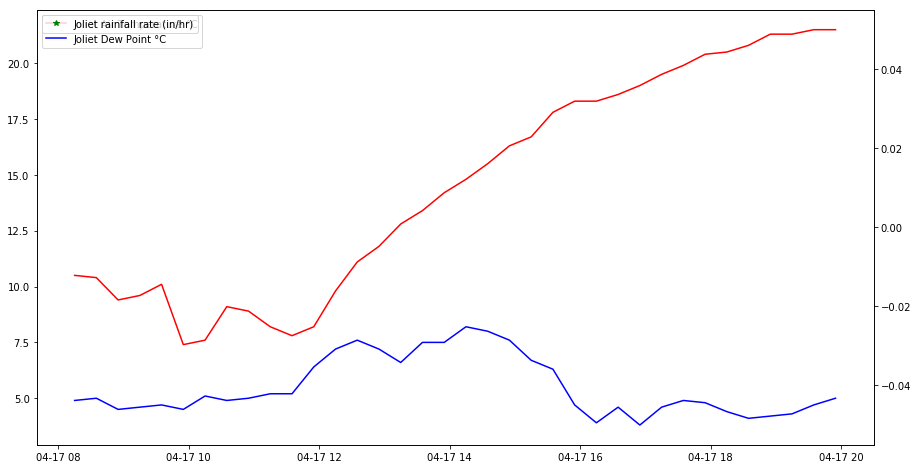

In [15]:

#make a nice visual!
fig = plt.figure(figsize = [15,8])
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['air_temperature'], 
         'r-', label=u'Joliet Air Temperature \u00b0C')
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['dew_point_temperature'], 
         'b-', label=u'Joliet Dew Point \u00b0C')
plt.legend()
ax2= plt.twinx()
plt.plot(station_dict['KLOT']['time'], 
         station_dict['KLOT']['precipitation_amount_hourly'], 'g*',
        label='Joliet rainfall rate (in/hr)')
plt.legend(loc=2)
plt.savefig('../images/KLOT.png')

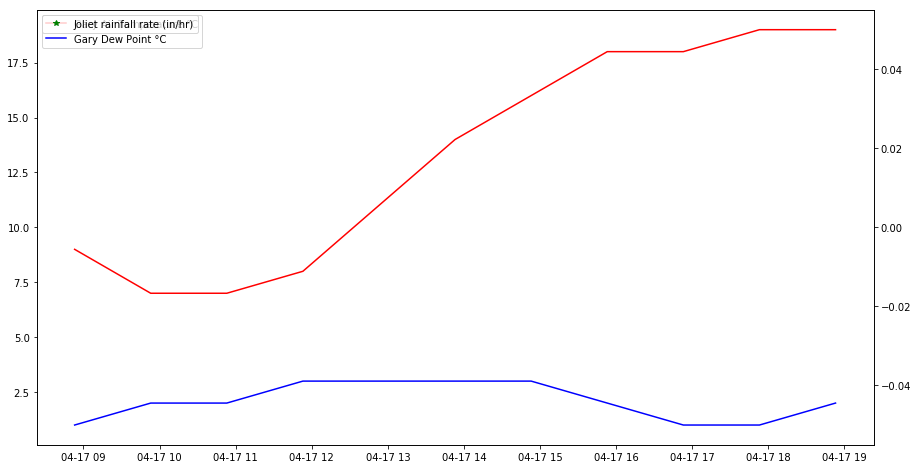

In [16]:

#make a nice visual!
fig = plt.figure(figsize = [15,8])
plt.plot(station_dict['KGRR']['time'], 
         station_dict['KGRR']['air_temperature'], 
         'r-', label=u'Gary Air Temperature \u00b0C')
plt.plot(station_dict['KGRR']['time'], 
         station_dict['KGRR']['dew_point_temperature'], 
         'b-', label=u'Gary Dew Point \u00b0C')
plt.legend()
ax2= plt.twinx()
plt.plot(station_dict['KGRR']['time'], 
         station_dict['KGRR']['precipitation_amount_hourly'], 'g*',
        label='Joliet rainfall rate (in/hr)')
plt.legend(loc=2)
plt.savefig('../images/KGRR.png')

In [12]:
#Where to save the data.. and create a header for each CSV file
out_dir = '/Users/scollis/projects/precip_change/data/'
headers = ''
for key in list(station_dict[list(station_dict.keys())[0]].keys()):
    headers += key +","
headers = headers[:-1]+'\n'

#For each station create a CSV file of the data
for key in station_dict.keys():
    print(key)
    fh = open(os.path.join(out_dir, key+'.csv'), 'w')
    fh.write(headers)
    varss = list(station_dict[key].keys())
    for i in range(len(station_dict[key][varss[0]])):
        this_line =''
        for vkey in varss:
            this_line += str(station_dict[key][vkey][i])+','
        this_line = this_line[:-1]+'\n'
        fh.write(this_line)
    fh.close()



KOKK
KBEH
KARR
KETB
KBIV
KFLD
KDPA
KSBN
KVPZ
KENW
KIGQ
KLDM
KPWK
KGYY
KAZO
KC09
KLWA
KLOT
KUGN
KRQB
KMDW
KGSH
KHAI
KOEB
KMWC
KJOT
KGUS
KEKM
KIRS
KORD
KBTL
KMKE
KIKK
KASW
KMKG
KGRR
KUES
KBUU
KRAC
KFWA
KSBM


In [ ]:

#Just to make sure, lets plot the location of all our METARS
tk = .5
north = bb['north']
south = bb['south']
west = bb['west']
east = bb['east']
bbox = [west, east, south,north]

fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(west, east, tk), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(south, north, tk), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_extent(bbox)
ax.add_feature(cfeature.LAKES, edgecolor='k')
ax.add_feature(cfeature.RIVERS)
states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
_ = ax.add_feature(states, edgecolor='gray')
for station_name in list(locs.keys()):
    ax.plot(locs[station_name][1], locs[station_name][0], 'ro')
    ax.text(locs[station_name][1], locs[station_name][0], station_name)
plt.savefig('../images/locations_midwest.png')